# Cell 1: Importing Libraries and Setup
This cell imports the necessary libraries for the notebook:

- os: Interacts with the operating system (used to list and manipulate files).
- pdf2image: Converts PDF pages to images.
- pytesseract: Performs OCR to extract text from images.
- AzureOpenAI: Interface to interact with OpenAI's GPT models via Azure.

Additionally, the following parameters are loaded from files:

- api_key: The API key to access Azure services.
- azure_endpoint: The endpoint for Azure OpenAI API.
- azure_deployment: The model deployment name for the Azure OpenAI API.
- A client is initialized to interact with OpenAI's Azure service.

In [1]:
import os
import pdf2image
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
from openai import AzureOpenAI


archive_path = "DemoArkiv"

with open("GPT.key", "r") as f:
    api_key = f.read()
with open("GPT.endpoint", "r") as f:
    azure_endpoint = f.read()
with open("GPT.deploymentName", "r") as f:
    azure_deployment = f.read()

client = AzureOpenAI(
    api_key=api_key,
    api_version="2024-02-01",
    azure_endpoint=azure_endpoint,
    azure_deployment=azure_deployment
) 

# Cell 2: Creating the linked list
This cell defines the DocNode class, which represents a document in a linked list structure. Each DocNode holds:

- next_node: A reference to the next document node.
- chunks: A dictionary to store the chunks of the document.
- chunk_list: A list of chunks for the document.
- summary: A summary of the document.
- id: The unique identifier for the document.
- date_string: The date the document was created or processed.

The cell then creates the linked list by reading the PDF files in the `pdfs` directory and creating a DocNode for each file. The linked list is created in the order of the PDF files in the directory.

In [2]:
class DocNode:
    def __init__(self, id) -> None:
        self.next_node = None
        self.chunks = {}
        self.chunk_list = []
        self.summary = ""
        self.id = id
        self.date_string = "" #format is YYYYMMDD

# Create linked list of nodes containing doc id in chronlogical order
files = [f for f in os.listdir(archive_path)]
#files = files[15:25]
# Only using first 20 files as gpt gets confused by some relations, longer sequences break it more consistently.
# Can probably be fixed by better prompts, be stricter about when to re-query gpt, change the prompt on re-query, or use a different model.
files = files[:20] 
files.sort()
root = None
head = None
while len(files) > 0:
    file = files.pop(0)
    print(file[37:-4])
    node = DocNode(int(file[37:-4]))# Doc ID is locataed from 37th first to the 5th last character of file name
    if root == None:
        root = node
        head = node
        print(head.id)
        continue
    head.next_node = node
    head = node
    print(head.id)

20045214
20045214
20048434
20048434
20055571
20055571
20070586
20070586
20077880
20077880
20080517
20080517
20082760
20082760
20087062
20087062
20093389
20093389
20111554
20111554
20114107
20114107
20114598
20114598
20131411
20131411
20132483
20132483
20145127
20145127
20151089
20151089
20273009
20273009
20428060
20428060
20436522
20436522
20436533
20436533


# Cell 3: Text extraction and initial processing
This cell defines several functions for processing the text from the documents:

- get_text(id): Converts the specified PDF to images and uses OCR to extract text.
- get_date_from_gippity(text): Uses GPT to extract the date from the provided text in a specified format (DD-MM-YYYY).
- get_chunks_from_gippity(text): Uses GPT to divide the text into meaningful sections (chunks) based on semantic content.
- we_chunk_it(text): Uses a semantic text splitter to break the text into chunks, ensuring each chunk is under a specified character limit.

With the exception of "we_chunk_it" the functions utilize GPT models to process and interpret the text extracted from the documents.
we_chunk_it uses semantic chunking to break the text into smaller pieces, ensuring that we retain the correct text, as GPT can take some "creative liberties" when splitting the text.

The cell also performs the following operations for each node in the linked list:
- Extracts the text from the documents with the get_text function.
- Extracts the date from the text using GPT models.
- Divides the text into chunks.

In [3]:
def get_text(id): # should look into foundation model ocr for time efficiency + accuracy
    template = os.listdir(archive_path)[0][:37]
    file = template + str(id) + '.pdf'
    imgs = pdf2image.convert_from_path(archive_path + '/' + file)
    text = ""
    for pg_nr, img in enumerate(imgs):
        pg_content = pytesseract.image_to_string(img, lang="nor")
        text = text + " " + pg_content
    return text

def get_date_from_gippity(text):
    # Ask GPT nicely for date :)
    sys_msg = '''
    You are an assistant that figures out when the verdict in a provided document was decided (this information is in the document text). 
    Your answer should be in the format: DD-MM-YYYY
    '''

    response = client.chat.completions.create(
    model=azure_deployment,
    messages=[
        {"role": "system", "content": sys_msg},
        {"role": "user", "content": text}
    ]
    )
    response_text = response.choices[0].message.content
    dd, mm, yyyy = response_text.split("-")
    date_string = f"{yyyy}{mm}{dd}"

    return date_string

def get_chunks_from_gippity(text):
    # Ask GPT nicely for chunks :)
    sys_msg = '''
    Split the text into sections with atomic semantic meanings, meaning each section should have 1 connotation. Respond by listing the sections.
    Example:
    Q. Det var en gang i Krarup Kro en pike, som het Karen. Hun var alene om oppvartningen; for Kromannens kone gikk nesten alltid omkring og lette efter sine nøkler... Men når gamle folk ville gi ungdommen en riktig alvorlig advarsel pleide de gjerne å begynne således: ”Det var en gang i Krarup Kro en pike som het Karen”
    A. Det var en gang i Karup Kro en pike, som het Karen.
    Karen. Hun var alene om oppvartningen;
    for Kromannens kone gikk nesten alltid omkring og lette efter sine nøkler
    ...
    Men når gamle folk ville gi ungdommen en riktig alvorlig advarsel pleide de gjerne å begynne således:
    advarsel ”Det var en gang i Krarup Kro en pike som het Karen”
    Do not use indexing numbers.
    '''

    response = client.chat.completions.create(
    model=azure_deployment,
    messages=[
        {"role": "system", "content": sys_msg},
        {"role": "user", "content": text}
    ]
    )
    response_text = response.choices[0].message.content
    chunks = response_text.split("\n")

    return response_text, chunks

def we_chunk_it(text):
    from semantic_text_splitter import TextSplitter 
    # Maximum number of characters in a chunk, 1000 has been used as a value during testing with not any particular reasoining, feel free to test with other values
    max_characters = 1000
    splitter = TextSplitter(max_characters)

    chunks = splitter.chunks(text)
    return None, chunks

head = root
while head.next_node:
    if head.chunk_list != []:
        head = head.next_node
    text = get_text(head.id)
    date_string = get_date_from_gippity(text)
    head.date_string = date_string
    #string_chunks, chunk_list = get_chunks_from_gippity(text)  
    # We can chunk the text either using a language model agent, or by using a semantic chunker. Have not determined which is better yet, 
    # but the language model agent does change the text so a stricter re-query policy is needed, we can perhaps also improve on the prompt.
    string_chunks, chunk_list = we_chunk_it(text)
    head.chunk_list = chunk_list
    print(head.id)
    

20045214
20048434
20055571
20070586
20077880
20080517
20082760
20087062
20093389
20111554
20114107
20114598
20131411
20132483
20145127
20151089
20273009
20428060
20436522
20436533


In [4]:
print(head.chunk_list)

["SONGDALEN KOMMUNE '\nTEKNISK ENHET å\n\nSongdalen kommune v/Johnny Greibesland\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\nPostboks 53\nostboks -9 JUN 2009\n4685 NODELAND\nVår ref. Deres ref. Dato:\n09/726-4/GBR-110//DBJ 05.06.2009\nDelegert vedtak\nSAKSGANG\n'Styre, utvalg, komité m.m. Møtedato f Saksnr. Saksbeh.\n| Delegert planutvalget 05.06.2009] 12309 | DBJ\nAvgjort av: Arkiv: GBR-110/ Arkivsaknr:\nSaksansv.: Diddi Bjoraa Objekt: 09/726 -3\n\n \n\n \n\n \n\nTillatelse til fradeling - Songdalsvegen 57 gnr. 110 parsell av bnr. 44 -\nSongdalen kommune\n\nFølgende dokumenter foreligger:\nNr T Dok.dato Avsender/Mottaker Tittel\n\n1 I 06.05.2009 PTL v/Gunnar Grana Delingssøknad Songdalsvegen 57 gnr.\n110 parsell av bnr. 44\n\nSaksutredning:\n\nSøknad:\nDet søkes om fradeling av parsell på 3230 m? fra gnr. 110 bnr. 44, Songdalsvegen 57.\nParsellen skal benyttes til rådhus, offentlige kontorer og legesenter.\n\nGjeldende plangrunnlag:", 'Eiendommen omfattes av reguleingsplan for Fagermoe

In [5]:
head = root
node_list = []
while head.next_node:
    if node_list != []:
        head = head.next_node
    node_list.append(head)
print(len(node_list))

copy_node_list = node_list.copy()

20


# Cell 4: Sorting the linked list
This cell sorts the document nodes by date and rebuilds the linked list with the sorted nodes. The nodes are linked such that the next_node points to the subsequent document in chronological order.

In [6]:
node_list = copy_node_list
root = copy_node_list[0]

node_list.sort(key=lambda node: node.date_string)
print(len(node_list))

for n, node in enumerate(node_list):
    if n == len(node_list)-1:
        node.next_node = None
        break
    node.next_node = node_list[n+1]
print(len(node_list))

root = node_list[0]


20
20


# Cell 5: Ordering the chunks with GPT
This cell defines the order_chunks_with_gippity function, which orders chunks of text based on their importance using GPT. It then applies this function to all document nodes in the linked list, reordering the chunks accordingly. We do this to later save ourselves the computing effort required to process the entire document and instead only check for relations in the most important parts.

In [7]:
def order_chunks_with_gippity(chunk_text):
    # Ask GPT nicely to order chunks :)
    sys_msg = """
    Order the list of chunks from most to least important in regards to the result of the application(if the application was approved or not).
    Example:
    Q.
    Arne sender naboklage
    Kommunen sier det er ulovlig å bygge garasje
    Beate sin bil er blå.'
    Navn: Beate
    Beate får ikke lov til å bygge garasje
    A. 
    'Beate får ikke lov til å bygge garasje
    Kommunen sier det er ulovlig å bygge garasje
    Arne sender naboklage
    Beate sin bil er blå.'
    Navn: Beate

    Note that facts used in example are not necessarily indicative of real world importance or rules. Do not use indexing numbers. Do not change the content of the chunks. Do not combine or seperate chunks.
    """

    response = client.chat.completions.create(
    model=azure_deployment,
    messages=[
        {"role": "system", "content": sys_msg},
        {"role": "user", "content": chunk_text}
    ]
    )

    response_text = response.choices[0].message.content
    ordered_chunks = response_text.split("\n")
    print(len(ordered_chunks))

    return response_text, ordered_chunks

head = root
while head.next_node:
    chunk_string = "\n".join(head.chunk_list)
    #print("NEW CHUNK STRING: " + chunk_string)
    sorted_chunk_string, sorted_chunk_list = order_chunks_with_gippity(chunk_string)
    print(head.id)
    head = head.next_node
chunk_string = "\n".join(head.chunk_list)
sorted_string_chunks, sorted_chunk_list = order_chunks_with_gippity(chunk_string)    
print(head.id)

41
20131411
53
20114598
22
20077880
24
20048434
9
20114107
36
20087062
93
20145127
33
20055571
28
20093389
39
20132483
59
20080517
18
20082760
94
20151089
15
20070586
45
20273009
121
20045214
86
20436522
27
20436533
61
20111554
78
20428060


In [8]:
print(head.chunk_list)
print(sorted_chunk_list)

['Delegert vedtak\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\nSAKSGANG\nStyre, utvalg, komité m.m. Møtedato Saksnr. Saksbeh.\nDelegert planutvalget 06.10.2009 250/09 KSB\nAvgjort av: Arkiv: GBR-110/658 | Arkivsaknr:\nSaksansv.: Kim Stefan Bringsdal Objekt: 09/1411 -4\n\n \n\nSeksjonering gnr. 110 bnr. 658 Songdalsvn. - Songdalen kommune\n\n \n\nSaksopplysninger:\n\nAdresse: Gnr/Bnr/Fnr/Snr:\nSongdalsvegen 53 110/658//\nTiltakshaver: Adresse:\n\nSongdalen kommune\n\nAnsyv. søker:\nAdvokatfullmektig Harald Martens\n\nPostboks 53, 4685 NODELAND\n\n \n\nAdresse:\n\nProsjekt og teknologiledelse AS,\nLømslandsvei 23, Serviceboks 637, 4606\nKRISTIANSAND\n\n \n\nTiltakstype:\nSeksjonering\n\nSaken er komplett:\n\n \n\n \n\nBruksareal:\n\n1 etg 1750m— 2Zetg 1360m2\nkjeller 1150m2\nAntall dager saken er behandlet:\nCa.30 dager\n\n \n\nFølgende dokumenter foreligger:\nNr T Dok.dato Avsender/Mottaker\n\n1 I 18.09.2009 PTL\n\nSaksutredning:\n\nSøknad:\n\nTittel\n\nSeksjonering gnr. 110 bnr. 658

# Cell 6: Finding related chunks with GPT
This cell defines find_related_chunks_with_gippity, which identifies relationships between chunks of different documents (e.g., one document may affect or change the meaning of a chunk in another). The function is called for each pair of documents in the linked list.
The format of the relation from gpt should be as follows:

"id of chunk in document 1 (the document we are currently looking at in the linked list)-id of chunk in document 2 (the document we are comparing to, this always occurs earlier in the linked list, as documents do not relate to documents that do not exist yet)"

Example:

3-2 (meaning the 3rd most important chunk in the current document relates to the 2nd most important chunk in the other document we are currently looking at)

We save each node's relations in a list in a dictionary (in a dictionary, namely in the chunks dictionary at key_value=chunk_text), where each relations is a tuple of the form (document 2 node, document 2 chunk id, document 1 chunk id)

In [9]:
NUMBER_OF_CHUNKS_TO_CONSIDER = 15 # import numpy as np - use np.inf to include all chunks

def find_related_chunks_with_gippity(current_head, earlier_head):
    sys_msg = """
    Do any of the chunks from document1 affect any of the chunks from document2? If so which ones?
    A chunk is affected if that chunk's effect on a verdict of accepted/not accepted on a building matter application is altered.
    Assume that document1 is newer than document2.
    If no chunk affects any other chunk: reply 0-0.
    Else: list the chunk relations (there can be one to many relations)
    The format is: 
    chunk_id_in_document_1-chunk_id_in_document_2

    Do not use indexing numbers.

    Example 1:
    Document1:
    1. Garasjen skal bygges på tomte grensen
    ...
    2. Nabo har signert at de vil ha garasje
    ...
    3. Garasjen skal være fin
    ...
    4. Garasjen skal være lav
    ...
    Document2:
    1. Garasjen skal bygges på tomte grensen
    ...
    2. Naboklage
    ...
    3. Garasjen skal være høy
    ...

    Answer:
    2-1
    4-3

    Example 2:
    Document1:
    1. Terassen skal være fin
    ...
    2. Terassen er plassert midt på tomten
    ...
    3. Fylkesmann har godkjent terasse
    ...
    Document2:
    1. Garasjen skal bygges på tomte grensen
    ...
    2. Naboklage
    ...
    3. Garasjen skal være høy
    ...

    Answer: 
    0-0

    Note: having two integers seperated by a - (dash) as the output is important. Never return alphabetic characters.
    """

    document1 = ""
    for i in range(min(NUMBER_OF_CHUNKS_TO_CONSIDER, len(current_head.chunk_list))):
        document1 = document1 + f"{i+1}. {current_head.chunk_list[i]}\n...\n"
    document2 = ""
    for i in range(min(NUMBER_OF_CHUNKS_TO_CONSIDER, len(earlier_head.chunk_list))):
        document2 = document2 + f"{i+1}. {earlier_head.chunk_list[i]}\n...\n"
        
    response = client.chat.completions.create(
    model=azure_deployment,
    messages=[
        {"role": "system", "content": sys_msg},
        {"role": "system", "content": document1},
        {"role": "user", "content": document2}
    ]
    )
    response_text = response.choices[0].message.content
    relation_list = response_text.split("\n")
    relation_list = list(filter(None, relation_list))
    #print(relation_list)

    if '0-0' in relation_list:
        return
    
    for relation in relation_list:
        try:    # If the relation is not in the correct format so things break, re-query GPT
            c1, c2 = relation.split('-')
            c1 = int(c1)    # NB! this is chunk_id, not document index in linked list
            c2 = int(c2)    # NB! this is chunk_id, not document index in linked list
            if current_head.chunk_list[c1-1] not in current_head.chunks.keys(): # Initialize chunk if it does not exist
                current_head.chunks[head.chunk_list[c1-1]] = {
                    "importance": c1-1,     # Lower score means more important, best score is 0
                    "relations": []
                }
            current_chunk = current_head.chunk_list[c1-1]
            relations_of_current_chunk = current_head.chunks[current_chunk]["relations"]
            relations_of_current_chunk.append((earlier_head, c2-1, c1-1))
            if c2 > len(earlier_head.chunk_list) or c2 > NUMBER_OF_CHUNKS_TO_CONSIDER:  #  re-query GPT if the chunk_id is out of bounds
                find_related_chunks_with_gippity(current_head, earlier_head)
        except:
            find_related_chunks_with_gippity(current_head, earlier_head)
            break
            

import time
head = root
while head.next_node:
    start_time = time.time()
    head = head.next_node
    head2 = root
    while head2 != head:
        find_related_chunks_with_gippity(head, head2)
        head2 = head2.next_node
    end_time = time.time()
    print(end_time-start_time)


0.9024732112884521
4.996300220489502
2.417649745941162
1.146134376525879
16.37199306488037
38.79080820083618
11.794200658798218
39.699023962020874
19.523771047592163
48.67475724220276
77.72160148620605
135.02923607826233
152.71488642692566
62.30447554588318
183.43189978599548
76.62375354766846
123.59311437606812
207.9775664806366
122.4686164855957


In [10]:
# Give chunks without relations a default value
head = root
while head.next_node:
    for i, chunk in enumerate(head.chunk_list):
        if chunk not in head.chunks:
            head.chunks[head.chunk_list[i]] = {
                    "importance": i,
                    "relations": []
                }
    head=head.next_node
for i, chunk in enumerate(head.chunk_list):
        if chunk not in head.chunks:
            head.chunks[head.chunk_list[i]] = {
                    "importance": i,
                    "relations": []
            }

print(head.chunks)

{'Begjæring om seksjonering for gnr.110, bnr.658.På eiendommen er det bygget nytt rådhus og\ndet er dette som ønskes seksjonert. Rådhuset består av en underetasje til parkering,\nhovedetasje, andre etasje og loftsetasje. Området er regulert og er satt av til offentlig\nbebyggelse i reg.plan for Fagermoen vedtatt 30.08.2006 av kommunestyret med siste endring\n29.04.08. Bebyggelsesplan for Fagermoen er vedtatt 17.09.2009 av planutvalget.\n\nAdkomist:\n\nI bebyggelsesplanen er det satt av avkjørsel mot offentlig veg.\n\x0c TILLATELSE\n\nSvar på søknad om tillatelse for tiltak etter eierseksjonsloven $ 9\nSeksjonering av næringsbygg på eiendommen gnr.110, bnr.658.\nI medhold av eierseksjonsloven $9 godkjennes søknaden om seksjonering.': {'importance': 1, 'relations': [(<__main__.DocNode object at 0x7f4bc00d9e80>, 1), (<__main__.DocNode object at 0x7f4b80338a00>, 3), (<__main__.DocNode object at 0x7f4b80338a00>, 0), (<__main__.DocNode object at 0x7f4b80338a90>, 1), (<__main__.DocNode object

# Cell 7: Generating summaries with GPT
This cell defines the function get_summary_from_gippity, which uses GPT to generate summaries of the documents based on their chunks and relations. It then generates summaries for all documents in the linked list

In [11]:
def get_summary_from_gippity(doc):
    sys_msg = """Du er en KI assistent som oppsummerer PDFer. Oppsummer PDFen i henhold til tittel og den viktigste informasjonen i PDFen,
                den aller viktigste informasjonen er om søknaden er godkjent. Du skal oppsummere PDFen på under 30 ord. Ikke bruk addresse,
                navn, eller GNR/BNR (gårdsnummer/bruksnummer) i oppsummeringen. Om referanse til personer eller eiendom er viktig for oppsummering
                erstatt navn med funksjonsnavn som 'søker' eller 'søkers nabo' og adresse med eksempler som 'søkers eiendom' eller 'klagers eiendom'.
                Begynn alltid med år; ÅÅÅÅ: Dispensasjon godkjent/avslått, <pdf info>
                Du får i tillegg oppgitt de viktigste delene av teksten.
                Du får også oppgitt informasjon dette dokumentet endrer som var korrekt inntil dette dokumentet var vedtatt. Dette er ofte relevant for oppsummeringen.
                De relaterte delene er oppgitt i form av: "ny informasjon---gammel informasjon" eller 0---0 om det er ingen relaterte dokumenter.
                """


    important_chunks = ""

    for i, chunk in enumerate(doc.chunks.keys()):
        important_chunks = important_chunks + f"VIKTIG DEL {i+1}: {chunk}\n"

    related_chunks = ""

    # This is a bit of a mess, it doesn't work properly, problem probably being that we do not recognize that a chunk can have more than one relation
    # Also id_of_related_chunk can be out of range of chunk_list due to the LLM creating too many chunks when finding relations. (LLMs are bad at counting)
    # PS these ^ are working theories. 
    for chunk in doc.chunks:
        chunk_key = chunk
        chunk = doc.chunks[chunk_key]
        if chunk["relations"] == []:
            continue
        try:
            # Node that related chunk is in
            related_doc = chunk["relations"][0][0] # This is an object (node in linked list)

            id_of_related_chunk = chunk["relations"][0][1]
            related_chunk = related_doc.chunk_list[id_of_related_chunk]
        except:
            print(doc.id)
            print(chunk['relations'])
            print(chunk['relations'][0][1])
            print(chunk['relations'][0][0].chunk_list)
            print(len(chunk['relations'][0][0].chunk_list))
            raise Exception("Chunk not found")
        related_chunks = related_chunks + f"{chunk_key}---{related_chunk}\n"
    
    if related_chunks == "":
        related_chunks = "0---0"

    response = client.chat.completions.create(
    model=azure_deployment,
    messages=[
        {"role": "system", "content": sys_msg},
        {"role": "system", "content": important_chunks},
        {"role": "system", "content": related_chunks}
    ]
    )
    summary = response.choices[0].message.content

    head.summary = summary

head = root
while head.next_node:
    get_summary_from_gippity(head)
    head = head.next_node
get_summary_from_gippity(head)

In [12]:
head = root
while head.next_node:
    print(head.summary)
    head = head.next_node
print(head.summary)

1966: Dispensasjon godkjent, Songdalen kommune tillater oppføring av garasje 30 m fra senterlinje Riksvei 461 og 1,5 m fra grensen mot kommunens eiendom.
1975: Dispensasjon godkjent, søknad om utvidelse av banklokale for Søgne og Greipstad Sparebank i samsvar med bygningsloven og byggeforskrifter.
1981: Dispensasjon godkjent, midlertidig tillatelse til endring av vinduer og innsetting av ny dør.
1981: Dispensasjon godkjent, søknad om skifting av hovedinngangsdør og fjerning av dør mellom soverom og entre godkjennes midlertidig under forutsetning av helserådets godkjenning.
1981: Dispensasjon godkjent, oppføring av ramper for funksjonshemmede ved kommunehusene i trykkimpregnert materiale uten varsel til naboer.
1983: Dispensasjon godkjent, søknad om skifting av vindu fra 1,1 x 1,1 m til 1,20 x 1,6 m på "Solslett".
1988: Dispensasjon godkjent, bruksendring og oppussing av "Solslett" for kontorformål. Arbeidsmiljøutvalget godkjenner planløsning; flyktningekonsulenten og menighetskontoret 

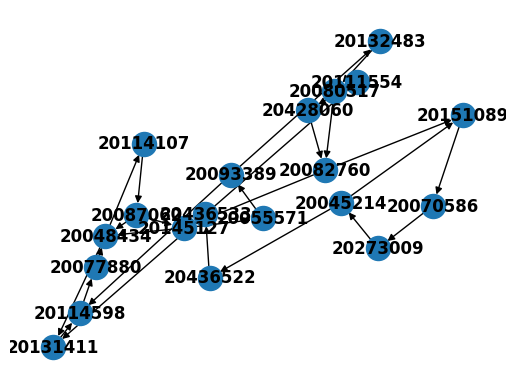

In [13]:
import networkx as nx

G = nx.DiGraph()

head = root
while head.next_node:
    if G.number_of_nodes() == 0:
        G.add_node(head.id)
        last_node = head.id
    head=head.next_node
    G.add_node(head.id)
    G.add_edge(last_node, head.id)
    last_node = head.id

head = root
while head.next_node:
    head=head.next_node
    has_relation = False
    for chunk in head.chunks:
        if head.chunks[chunk]["relations"] != []:
            has_relation = True
            relation_to = head.chunks[chunk]["relations"][0][0]
            break
    if has_relation:
        G.add_edge(head.id, relation_to.id)
    
import matplotlib.pyplot as plt
subax1 = plt.subplot(111)
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()


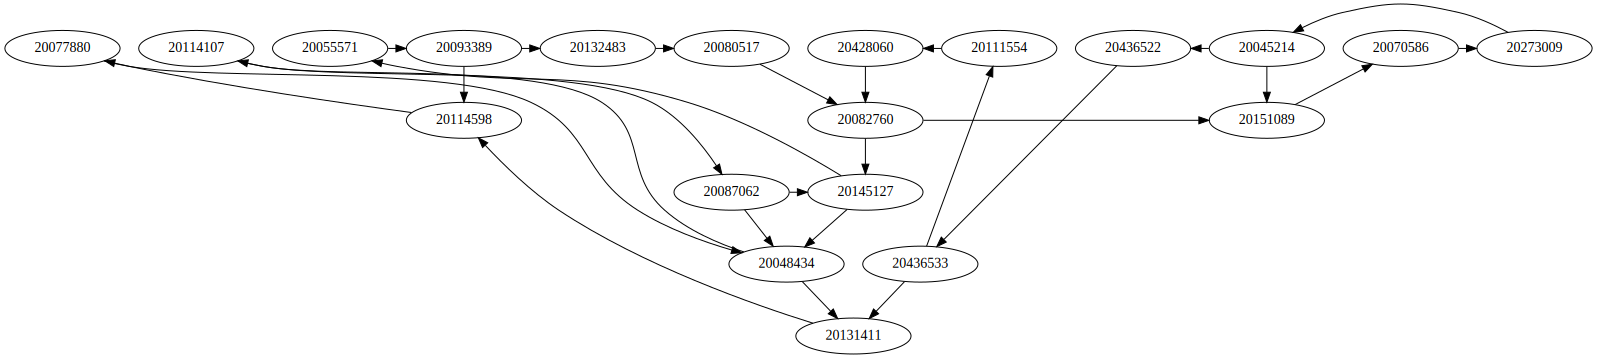

In [14]:
import graphviz  # doctest: +NO_EXE
dot = graphviz.Digraph(graph_attr={'splines': 'true'})
empty_dot = graphviz.Digraph(graph_attr={'splines': 'true'})

head = root
while head.next_node:
    if dot.source == empty_dot.source:
        dot.node(str(head.id), str(head.id))#head.summary)
        last_node = str(head.id)
    head=head.next_node
    dot.node(str(head.id), str(head.id))#head.summary)
    dot.edge(last_node, str(head.id), constraint = "false")
    last_node = str(head.id)


head = root
while head.next_node:
    head=head.next_node
    has_relation = False
    for chunk in head.chunks:
        if head.chunks[chunk]["relations"] != []:
            has_relation = True
            relation_to = head.chunks[chunk]["relations"][0][0]
            break
    if has_relation:
        dot.edge(str(head.id), str(relation_to.id))

dot

In [15]:
def get_master_summary_from_gippity(summaries):
    sys_msg = """
    Each line in the following text represents a summary of a document in the set of documets that describe all developments on a property. Summarize the total history of the property according to these summaries in list format.
    Example:
    1988 - Garasje gokjent.
    1991 - Terasse avslått på grunnlag av dårlig grunn.
    1994 - Utbygging på nord side av eiendom er godkjent så langt det males hvitt.
    """
        
    response = client.chat.completions.create(
    model=azure_deployment,
    messages=[
        {"role": "system", "content": sys_msg},
        {"role": "user", "content": summaries}
        ]
    )
    response_text = response.choices[0].message.content
    return response_text

head = root
summaries = ""
while head.next_node:
    if summaries != "":
        head = head.next_node
        summaries += "\n"
    summaries += head.summary

master_summary = get_master_summary_from_gippity(summaries)
print(master_summary)

1. 1966: Dispensasjon godkjent for oppføring av garasje.
2. 1975: Dispensasjon godkjent for utvidelse av banklokale for Søgne og Greipstad Sparebank.
3. 1981: Dispensasjon godkjent for endring av vinduer og ny dør (midlertidig tillatelse).
4. 1981: Dispensasjon godkjent for skifting av hovedinngangsdør og fjerning av dør mellom soverom og entre (midlertidig tillatelse).
5. 1981: Dispensasjon godkjent for oppføring av ramper for funksjonshemmede ved kommunehusene.
6. 1983: Dispensasjon godkjent for skifting av vindu på "Solslett".
7. 1988: Dispensasjon godkjent for bruksendring og oppussing av "Solslett" for kontorformål.
8. 1989: Dispensasjon godkjent for montering av lysskilt på kommunehuset.
9. 1989: Dispensasjon godkjent for omdisponering av tidligere banklokale til kontorer for skoleadministrasjonen.
10. 1999: Dispensasjon godkjent for innsetting av vindu i Songdalen rådhus.
11. 1999: Dispensasjon godkjent for oppføring av to informasjonsskilt ved Songdalen rådhus og helsesenter.
1

In [16]:
def get_super_master_summary_and_description_from_summary_from_gippity(master_summary):
    sys_msg = "From the following history of the property create a coherent text as a master summary and a paragraph describing the property as it is today."
    
    response = client.chat.completions.create(
    model=azure_deployment,
    messages=[
        {"role": "system", "content": sys_msg},
        {"role": "user", "content": master_summary}
        ]
    )
    response_text = response.choices[0].message.content
    return response_text

super_master_summary_and_description = get_super_master_summary_and_description_from_summary_from_gippity(master_summary)
print(super_master_summary_and_description)

## Master Summary
The property has undergone multiple changes and developments over the years, starting in 1966 with the approval to build a garage. In 1975, an extension was permitted for the local bank, Søgne og Greipstad Sparebank. By 1981, several temporary dispensations allowed for modifications such as changes to windows and doors, as well as the construction of ramps for the disabled at municipal houses. In subsequent years, from 1983 to 1989, there were dispensations for window replacements, change of use and refurbishment of buildings for office purposes, installation of light signs on the municipal house, and conversion of the previous bank premises into school administration offices.

The late 1990s saw more updates, including the installation of new windows and informational signs at the Songdalen Town Hall, and a use change from office space to a youth center in 2000. Major developments took place in 2008 with approvals for constructing a new administrative and commercial 

In [17]:
head = root
while head.next_node:
    for chunk in head.chunks:
        if head.chunks[chunk]["relations"] != []:
            print(head.id, head.chunks[chunk]["relations"][0][0].id)
    head = head.next_node
for chunk in head.chunks:
        if head.chunks[chunk]["relations"] != []:
            print(head.id, head.chunks[chunk]["relations"][0][0].id)

20048434 20131411
20087062 20048434
20145127 20048434
20093389 20114598
20082760 20145127
20045214 20151089
20436533 20131411
20428060 20082760
20428060 20151089
